In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision as tv
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt



###UP IS ORIGIN

import math
import torch.optim as optim


### SEC 3
from torchvision.utils import save_image






# custom dataloader for .npy file
class numpyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.from_numpy(data).float()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x
    
    def __len__(self):
        return len(self.data)


In [2]:
### Setting up Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Below codes activates when want to use cpu
#device = torch.device('cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 1050
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
transform       = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                            ])

print("Load traindata..")
# for training

BATCH_SIZE = 400

traindata       = np.load('train.npy')
traindataset    = numpyDataset(traindata, transform)
trainloader     = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

print("Train data is ready")


Load traindata..
Train data is ready


In [4]:
size_img = 120 * 80
size_layer_1 = 100
size_layer_2 = 50
size_layer_3 = 12
size_layer_4 = 3

class autoencoder(nn.Module):

    def __init__(self) :
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential (
            nn.Conv2d(1, 6, kernel_size = 3),
            nn.ReLU(True),
            nn.Conv2d(6,16,kernel_size=5),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16,6,kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(6,1,kernel_size=3),
            nn.ReLU(True))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

    
max_epochs = 60000 # For prevent system down

learning_rate = 1e-5

In [11]:
model = autoencoder().cuda()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()

In [12]:
epoch_history = []
epoch_loss_history = []
epoch_loss_std_history = []
exit_flag = 0

for epoch in range(max_epochs):
    # =========== Saving Origin imgs =========== #
    if epoch == 0 :
        for data in enumerate(traindata) :
            img = torch.tensor(data[1]).cuda()
            to_img = transforms.ToPILImage()
            pic_origin = to_img(img.view(120,80).cpu())
            pic_origin.save('./mlp_img/{}_origin.jpg'.format(data[0]))

    # ================= Train ===================
    loss_logs = []
    for data in enumerate(trainloader):
        
        order = data[0]
        img = data[1].clone().detach()
   
        img = img.cuda()
     
        # Create Noisy img
        
        # Random sigma between 0.01 - 0.04
        noise_level = torch.tensor(0.01) + torch.rand(1) * 0.03
        normal_distrib = torch.distributions.Normal(torch.tensor([0.0]),noise_level)
        noise = normal_distrib.sample(img.shape).view(img.shape).cuda()
        
        noisy_img = img + noise
        
        # ===================forward=====================
        output = model(noisy_img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        loss_logs.append(loss.item())
        optimizer.step()
        
        
        # ================= This code for Debug ====================#
        if epoch == 1 :
            if order == 2 :
                to_img = transforms.ToPILImage()
                pic_origin = to_img(img[2].view(120,80).cpu())
                pic_origin.save('./train_img/{}_origin.jpg'.format(21))
                
                pic_origin = to_img(img[6].view(120,80).cpu())
                pic_origin.save('./train_img/{}_origin.jpg'.format(25))
            else :
                to_img = transforms.ToPILImage()
                pic_origin = to_img(img[3].view(120,80).cpu())
                pic_origin.save('./train_img/{}_origin.jpg'.format(42))
            
                
        if order == 2 or order == 4 :
            if order == 2 :
                to_img = transforms.ToPILImage()
                
                ## 21
                pic_input = to_img(noisy_img[2].view(120,80).cpu())
                pic_input.save('./train_img/{}_{}_input.jpg'.format(21,epoch))
                 
                pic_output = to_img(output[2].view(120,80).cpu())
                pic_output.save('./train_img/{}_{}_output.jpg'.format(21,epoch))

                ## 25
                pic_input = to_img(noisy_img[6].view(120,80).cpu())
                pic_input.save('./train_img/{}_{}_input.jpg'.format(25,epoch))
                
                
                pic_output = to_img(output[6].view(120,80).cpu())
                pic_output.save('./train_img/{}_{}_output.jpg'.format(25,epoch))
            else :
                ## 42
                to_img = transforms.ToPILImage()
                pic_input = to_img(noisy_img[3].view(120,80).cpu())
                pic_input.save('./train_img/{}_{}_input.jpg'.format(42,epoch))
                
                
                pic_output = to_img(output[3].view(120,80).cpu())
                pic_output.save('./train_img/{}_{}_output.jpg'.format(42,epoch))
    epoch_loss = np.mean(loss_logs)
    epoch_loss_std = np.std(loss_logs)
        
    # ===================log========================
    print('[epoch {}], loss: (training) {:.10f}'
          .format(epoch, epoch_loss))
    
    
    # ================ loss diff check ============
    epoch_loss_history.append(epoch_loss)
    epoch_loss_std_history.append(epoch_loss_std)
    epoch_history.append(epoch)
    
    if epoch != 0 :
        loss_diff = abs(epoch_loss_history[epoch] - epoch_loss_history[epoch-1])
        if loss_diff <= 0.00001 :
            exit_flag += 1
            if exit_flag >= 2 :
                print("loss is converged")
                break
        else :
            exit_flag = 0
        

[epoch 0], loss: (training) 0.0298558137
[epoch 1], loss: (training) 0.0256683374
[epoch 2], loss: (training) 0.0225800125
[epoch 3], loss: (training) 0.0203503851
[epoch 4], loss: (training) 0.0188804511
[epoch 5], loss: (training) 0.0179321595
[epoch 6], loss: (training) 0.0173600770
[epoch 7], loss: (training) 0.0169881235
[epoch 8], loss: (training) 0.0167433479
[epoch 9], loss: (training) 0.0165928633
[epoch 10], loss: (training) 0.0164445618
[epoch 11], loss: (training) 0.0163150219
[epoch 12], loss: (training) 0.0161975220
[epoch 13], loss: (training) 0.0160863515


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

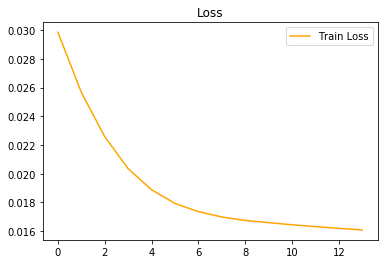

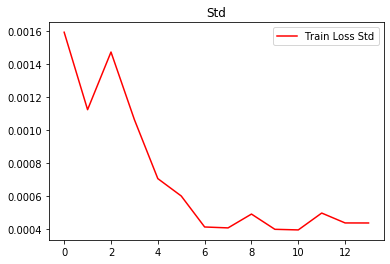

In [13]:

graph_x = []
graph_y = []

graph = plt.plot(epoch_history,epoch_loss_history, color = 'orange', label = 'Train Loss')
plt.title("Loss")
plt.legend(['Train Loss'])
plt.show()


graph_x = []
graph_y = []

graph = plt.plot(epoch_history,epoch_loss_std_history, color = 'red', label = 'Train Loss')
plt.title("Std")
plt.legend(['Train Loss Std'])
plt.show()


In [14]:


# for testing
testdata        = np.load('test.npy')
testdataset     = numpyDataset(testdata, transform)
testloader      = DataLoader(testdataset, batch_size=1, shuffle=False, num_workers=2)

result_for_submit = None    # this is for submit file

for batch_idx, data in enumerate(testloader):

    result_of_test = model(data.cuda())
    
    #print(result_of_test)
    
    if batch_idx == 0:
        result_for_submit = result_of_test
    else:
        try:
            result_for_submit = torch.cat([result_for_submit, result_of_test], dim=0)

        except RuntimeError:
            transposed = torch.transpose(result_of_test, 2, 3)
            result_for_submit = torch.cat([result_for_submit, transposed], dim=0)

            
       
result_for_submit = result_for_submit.cpu()
     


# the submit_file.shape must be (400,1,120,80) 
submit_file = result_for_submit.detach().numpy()
print("submit_file.shape :",submit_file.shape)

np.save('jesoonkang-2.npy', submit_file)
print("Test Result Save Success")



submit_file.shape : (400, 1, 120, 80)
Test Result Save Success
